In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
from importlib import reload

import torchvision
import os
from PIL import Image
from torch.optim.lr_scheduler import StepLR

In [30]:
1e-3

0.001

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [32]:
%reload_ext autoreload
%autoreload 2

from constants import csv_file, directory, INPUT_SHAPE, YEAR, ext

from utils import Dataset_Diabetic, data_class

from utils import (
    plot_samples,
    get_dataloader,
    plot_confusion_matrix,
    calculate_confusion_matrix,
    accuracy_fn,
    accuracy_sickness,
    get_accuracies,
    sample_iid,
)

from model import train_loop
from model import Model_Retinopathy, validate

from constants import EPOCHS, BATCH_SIZE, LEARNING_RATE, UPDATES
from constants import K_CLIENTS, C, rounds, clients

In [33]:
# MODEL STUFF
global_model = Model_Retinopathy().to(device)
models_ind = [Model_Retinopathy().to(device) for _ in range(K_CLIENTS)]
models_fed = [Model_Retinopathy().to(device) for _ in range(K_CLIENTS)]

for model in models_ind:
    model.set_weights(global_model.get_weights())
for model in models_fed:
    model.set_weights(global_model.get_weights())

loss_fn = nn.CrossEntropyLoss()
# Best loss function when talking about multi-class classification
optimizer = torch.optim.Adam(global_model.parameters(), lr=LEARNING_RATE)

In [34]:
# DATA STUFF
df = pd.read_csv(csv_file)

val_df = sample_iid(df, 0.05)
df = df.drop(val_df.index)
val_df = val_df.reset_index(drop=True)

df = sample_iid(df, 0.5).reset_index(drop=True)

samples = df.shape[0] // K_CLIENTS
train_df = []

while len(train_df) < K_CLIENTS - 1:
    df_sample = df.sample(n=samples)
    df.drop(df_sample.index, inplace=True)
    train_df.append(df_sample.reset_index(drop=True))
train_df.append(df.reset_index(drop=True))

datasets, loaders = [], []
for train_df_i in train_df:
    data, loader = get_dataloader(train_df_i, ext, directory, BATCH_SIZE, True)
    datasets.append(data)
    loaders.append(loader)

val_data, val_loader = get_dataloader(val_df, ext, directory, BATCH_SIZE, False)

In [35]:
losses = []
accuracies = []
losses_clients = [[] for _ in range(K_CLIENTS)]
accuracies_clients = [[] for _ in range(K_CLIENTS)]

In [36]:
def plot_accuracies():
    fig, ax = plt.subplots()
    for i in range(K_CLIENTS):
        ax.plot(accuracies_clients[i], "o-")
    ax.plot(accuracies, "-", label="Global", linewidth=5, color="blue")
    ax.set_title(f"Accuracies comparison, {K_CLIENTS} clients")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Accuracy")
    ax.legend()
    return ax


def plot_losses():
    fig, ax = plt.subplots()
    for i in range(K_CLIENTS):
        ax.plot(losses_clients[i], "o-")
    ax.plot(losses, "-", label="Global Loss", linewidth=5, color="blue")
    ax.set_title(f"Losses comparison, {K_CLIENTS} clients")
    ax.set_xlabel("Rounds")
    ax.set_ylabel("Loss")
    ax.legend()
    return ax

In [37]:
def save_plots():
    plt.ioff()

    ax = plot_losses()
    plt.savefig("Losses_fed.png")
    plt.close()

    ax = plot_accuracies()
    plt.savefig("Accuracies_fed.png")
    plt.close()

In [38]:
def fed_avg():
    m_clients = int(max(1, K_CLIENTS * C))
    for t in range(rounds):
        print("ROUND: ", t)
        print("-------------------------------" * 3)
        weight_global = global_model.get_weights()
        selected_clients = np.random.choice(clients, m_clients, replace=False)
        selected_clients.sort()

        weights = [0] * K_CLIENTS
        m_t = sum([len(datasets[i]) for i in selected_clients])
        for client in selected_clients:
            local_model = Model_Retinopathy().to(device)
            local_model.set_weights(global_model.get_weights())

            print("TRAINING CLIENT", client, "Federated")
            train_loop(
                local_model,
                loaders[client],
                val_loader,
                epochs=EPOCHS,
                lr=LEARNING_RATE,
                verbose=False,
            )
            print("TRAINING CLIENT", client, "Independent")
            train_loop(
                models_ind[client],
                loaders[client],
                val_loader,
                epochs=EPOCHS,
                lr=LEARNING_RATE,
                verbose=False,
            )
            weights[client] = local_model.get_weights()
            for layer in weights[client]:
                weights[client][layer] = (
                    weights[client][layer] * len(datasets[client]) / m_t
                )
            losses_clients[client].append(models_ind[client].get_loss(val_loader))
            accuracies_clients[client].append(
                models_ind[client].get_accuracy(val_loader)
            )
        for layer in weight_global:
            for i, client in enumerate(selected_clients):
                if i == 0:
                    weight_global[layer] = weights[client][layer]
                else:
                    weight_global[layer] = weights[client][layer] + weight_global[layer]
        global_model.set_weights(weight_global)
        loss = global_model.get_loss(val_loader)
        losses.append(loss)
        acc = global_model.get_accuracy(val_loader)
        accuracies.append(acc)
        print(f"Loss = {loss}, Acc = {acc}")

        save_plots()

In [39]:
# fed_avg()

In [40]:
from torch.optim import Optimizer


class ScaffoldOptimizer(Optimizer):
    def __init__(self, params, lr, weight_decay):
        defaults = dict(lr=lr)
        super(ScaffoldOptimizer, self).__init__(params, defaults)

    def step(self, server_controls, client_controls, closure=None):

        loss = None
        if closure is not None:
            loss = closure

        for group in self.param_groups:
            for p, c, ci in zip(
                group["params"], server_controls.values(), client_controls.values()
            ):
                if p.grad is None:
                    continue
                ## IMPLEMENT ADAM TO THIS CRAP
                dp = p.grad.data + c.data - ci.data
                p.data = p.data - dp.data * group["lr"]

        return loss

In [41]:
# Initializing control variables
for key, layer in global_model.named_parameters():
    global_model.control[key] = torch.zeros_like(layer.data)
    global_model.delta_control[key] = torch.zeros_like(layer.data)
    global_model.delta_y[key] = torch.zeros_like(layer.data)
for model in models_fed:
    for key, layer in model.named_parameters():
        model.control[key] = torch.zeros_like(layer.data)
        model.delta_control[key] = torch.zeros_like(layer.data)
        model.delta_y[key] = torch.zeros_like(layer.data)
for model in models_ind:
    for key, layer in model.named_parameters():
        model.control[key] = torch.zeros_like(layer.data)
        model.delta_control[key] = torch.zeros_like(layer.data)
        model.delta_y[key] = torch.zeros_like(layer.data)

In [42]:
m_clients = int(max(1, K_CLIENTS * C))
loss = global_model.get_loss(val_loader)
acc = global_model.get_accuracy(val_loader)
print(f"Loss = {loss}, Acc = {acc}")
for r in range(rounds):
    dash = "-"
    print(f"ROUND: {r}\n{dash * 50}")
    selected_clients = np.random.choice(clients, m_clients, replace=False)
    selected_clients.sort()
    x = copy.deepcopy(global_model)

    for client in selected_clients:
        print(f"TRAINING CLIENT {client}")

        # Fed part
        ## Dispatching the global model to the clients
        for old, new in zip(models_fed[client].parameters(), global_model.parameters()):
            old.data = new.data.clone()
        ## Training the client model

        # optimizer = torch.optim.SGD(
        #   models_fed[client].parameters(), lr=models_fed[client].lr
        # )
        optimizer = ScaffoldOptimizer(
            models_fed[client].parameters(), lr=models_fed[client].lr, weight_decay=1e-7
        )
        # lr_step = StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(EPOCHS):
            models_fed[client].train()
            for i, batch in enumerate(loaders[client]):
                inputs, y_true = batch["image"].to(device), batch["labels"].to(device)
                optimizer.zero_grad()
                outputs = models_fed[client](inputs)
                loss = loss_fn(outputs, y_true)
                loss.backward()
                optimizer.step(global_model.control, models_fed[client].control)
            # lr_step.step()
            validate(models_fed[client], val_loader)
        print("TRAINING INDEPENDENT...")
        train_loop(
            models_ind[client],
            loaders[client],
            val_loader,
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            verbose=False,
        )
        losses_clients[client].append(models_ind[client].get_loss(val_loader))
        accuracies_clients[client].append(models_ind[client].get_accuracy(val_loader))
        ## control variables update
        temp = {}
        for key, layer in models_fed[client].named_parameters():
            temp[key] = layer.data.clone()

        for key, layer in x.named_parameters():
            local_steps = EPOCHS * len(datasets[client])
            models_fed[client].control[key] = (
                models_fed[client].control[key]
                - global_model.control[key]
                + (layer.data - temp[key]) / (local_steps * models_fed[client].lr)
            )
            models_fed[client].delta_y[key] = temp[key] - layer.data
            models_fed[client].delta_control[key] = (
                models_fed[client].control[key] - x.control[key]
            )

    s = sum([len(datasets[i]) for i in selected_clients])
    x = {}
    c = {}

    for key, layer in models_fed[0].named_parameters():
        x[key] = torch.zeros_like(layer.data)
        c[key] = torch.zeros_like(layer.data)

    for client in selected_clients:
        for key, layer in models_fed[client].named_parameters():
            x[key] += models_fed[client].delta_y[key] / len(
                selected_clients
            )  # averaging
            c[key] += models_fed[client].delta_control[key] / len(
                selected_clients
            )  # averaging

    # update x and c
    for key, layer in global_model.named_parameters():
        layer.data += 1 * x[key].data  # lr=1
        global_model.control[key].data += c[key].data * (
            len(selected_clients) / len(clients)
        )
    loss = global_model.get_loss(val_loader)
    losses.append(loss)
    acc = global_model.get_accuracy(val_loader)
    accuracies.append(acc)
    print(f"Loss = {loss}, Acc = {acc}")

    save_plots()

Loss = 1.6919012069702148, Acc = 0.10382513661202186
ROUND: 0
--------------------------------------------------
TRAINING CLIENT 0
Validation Accuracy:  0.3934
Validation Loss:  1.5832
Validation Accuracy:  0.4918
Validation Loss:  1.4556
Validation Accuracy:  0.4918
Validation Loss:  1.3290
Validation Accuracy:  0.4918
Validation Loss:  1.2720
Validation Accuracy:  0.4918
Validation Loss:  1.2106
Validation Accuracy:  0.4918
Validation Loss:  1.2056
Validation Accuracy:  0.4918
Validation Loss:  1.1475
Validation Accuracy:  0.5027
Validation Loss:  1.1455
TRAINING INDEPENDENT...
Validation Accuracy:  0.3880
Validation Loss:  1.5683
Validation Accuracy:  0.4863
Validation Loss:  1.4407
Validation Accuracy:  0.4918
Validation Loss:  1.3554
Validation Accuracy:  0.4918
Validation Loss:  1.2735
Validation Accuracy:  0.4918
Validation Loss:  1.2355
Validation Accuracy:  0.4918
Validation Loss:  1.2005
Validation Accuracy:  0.4918
Validation Loss:  1.1644
Validation Accuracy:  0.4973
Valida

KeyboardInterrupt: 

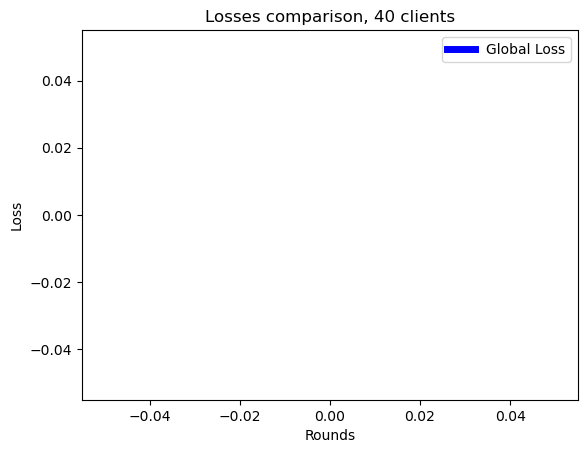

In [ ]:
ax = plot_losses()
plt.show()

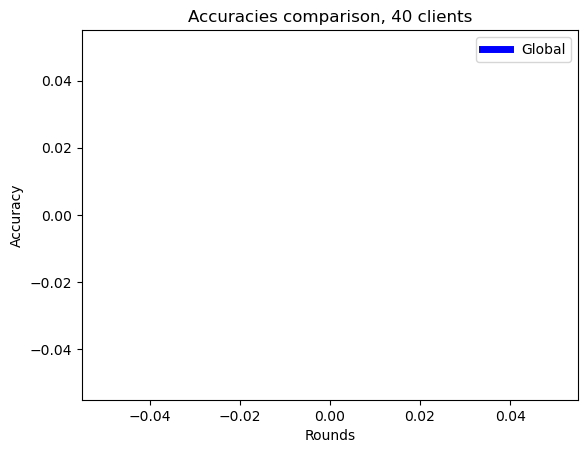

In [ ]:
ax = plot_accuracies()
plt.show()